In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Data

(array([ 128., 2192., 4808., 1766.,  104.,    5.,   83.,  447.,  403.,
          64.]),
 array([-6.58540928, -5.1285634 , -3.67171752, -2.21487165, -0.75802577,
         0.69882011,  2.15566598,  3.61251186,  5.06935774,  6.52620362,
         7.98304949]),
 <BarContainer object of 10 artists>)

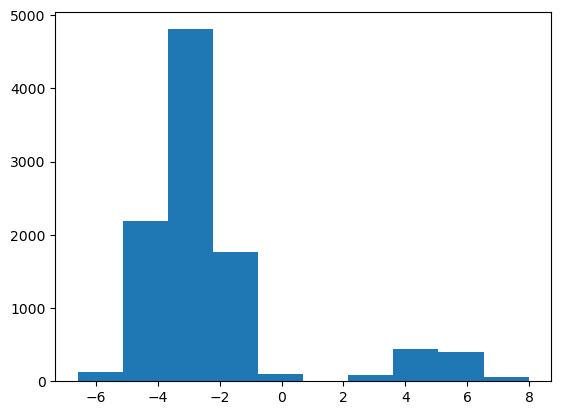

In [2]:
data_size = 10000
data_dim = 1
epsillon = 0.1
target_dist = np.random.normal(loc = -3, scale = 1, size = int(data_size*(1-epsillon)))
contaminated_dist = np.random.normal(loc = 5, scale=1, size = int(data_size*epsillon))
data = np.concatenate([target_dist, contaminated_dist])
data = data.astype(float)
plt.hist(data)

# Generator and Distcriminator

In [3]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.fc = nn.Linear(1, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 1)
        x = self.activation(self.fc(x.float()))
        return x


class generator(nn.Module):
    def __init__(self, mean):
        super(generator, self).__init__()
        self.mean = nn.Parameter(torch.zeros(data_dim))

    def forward(self, x):
        return x + self.mean

# Training

In [4]:
import torch.optim as optim

lr = 0.01

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G = generator(mean = 0).to(device)
D = discriminator().to(device)

G_optimizer = optim.SGD(G.parameters(), lr=lr, momentum= 0.9)
D_optimizer = optim.SGD(D.parameters(), lr=lr, momentum= 0.9)


In [12]:
loss = nn.BCELoss() #変えるかも
batch_size = 100
train_loader = DataLoader(data, batch_size=batch_size, shuffle= True)
epochs = 1000
for epoch in range(epochs):
    for idx, true_data in enumerate(train_loader):
        idx +=1
        real_inputs = true_data.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0],1).to(device)

        noise = torch.normal(mean = torch.zeros(batch_size,1), std = torch.ones(batch_size, 1))
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label  = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()


        noise = torch.normal(mean = torch.zeros(batch_size,1), std = torch.ones(batch_size, 1))
        noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones(fake_inputs.shape[0], 1).to(device)

        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        if idx%100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))

Epoch 0 Iteration 100: discriminator_loss 0.697 generator_loss 0.800
Epoch 1 Iteration 100: discriminator_loss 0.699 generator_loss 0.748
Epoch 2 Iteration 100: discriminator_loss 0.692 generator_loss 0.725
Epoch 3 Iteration 100: discriminator_loss 0.695 generator_loss 0.697
Epoch 4 Iteration 100: discriminator_loss 0.693 generator_loss 0.697
Epoch 5 Iteration 100: discriminator_loss 0.693 generator_loss 0.682
Epoch 6 Iteration 100: discriminator_loss 0.694 generator_loss 0.712
Epoch 7 Iteration 100: discriminator_loss 0.693 generator_loss 0.687
Epoch 8 Iteration 100: discriminator_loss 0.693 generator_loss 0.712
Epoch 9 Iteration 100: discriminator_loss 0.692 generator_loss 0.709
Epoch 10 Iteration 100: discriminator_loss 0.695 generator_loss 0.708
Epoch 11 Iteration 100: discriminator_loss 0.692 generator_loss 0.683
Epoch 12 Iteration 100: discriminator_loss 0.694 generator_loss 0.689
Epoch 13 Iteration 100: discriminator_loss 0.693 generator_loss 0.718
Epoch 14 Iteration 100: discri